In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
file = open('Processed_Non_Scammer_Database_2/database','r')
nsdb = json.load(file)
file.close()

In [3]:
file = open('Processed_Scammer_Database_2/database','r')
sdb = json.load(file)
file.close()

In [4]:
def prepare_data(database,identifier):
    ''' We will prepare the 11-dimensional dataset, 10 of which are direct the 11th is the id'''
    def convert_to_array(entry):
        rval = []
        
        rval.append(entry['spreads']['Incoming']['Total']) # Number of Addresses that send ETH to this address
        rval.append(entry['spreads']['Incoming']['Max'])   # The number of transactions with the address that made the most
        
        rval.append(entry['spreads']['Outgoing']['Total']) 
        rval.append(entry['spreads']['Outgoing']['Max'])
        
        rval.append(entry['means']['balances']['avg']) # Block weigthed -> (100*1ETH + 2ETH*200)/300
        rval.append(entry['means']['balances']['std']) 
        
        rval.append(entry['means']['transactions']['avg']) 
        rval.append(entry['means']['transactions']['std'])
        
        rval.append(entry['means']['time_between_transactions']['avg']) # Scammers tended to have auto withdrawals after a depo
        rval.append(entry['means']['time_between_transactions']['std']) # Standard deviation of itself 
        
        ''' Scenario 
            
            Time between trans:
            
                [ 1, 200, 1, 3829, 1, 438, 1, ... ] -
        
        '''
        
        rval.append(identifier)
        
        return rval
    
    uniques = {}
    data = []
    for entity in database:
        addresses = database[entity]
        for address in addresses:
            ''' Skip repeated '''
            if address['address'] in uniques.keys():
                continue   
            uniques[address['address']] = 1
            data.append(convert_to_array(address))
    return data

In [5]:
psdb = prepare_data(sdb,1)
pnsdb = prepare_data(nsdb,0)
full_database = psdb + pnsdb
random.shuffle(full_database)
full_database = np.asarray(full_database)

def renormalize(data):
    def compute_moments(index):
        local  = data[:,index]
        local2 = np.array([ d*d for d in local ])
        avg1  = local.sum()/len(data)
        avg2  = local2.sum()/len(data)
        return [avg1,np.sqrt(avg2-avg1*avg1)]
    
    moments     = [ compute_moments(i) for i in range(len(data[0])-1) ]
    moments.append([0,1])
    renorm_data = [ [ (data[i][j] - moments[j][0])/moments[j][1] for j in range(len(data[i])) ] for i in  range(len(data)) ]
    renorm_data = np.asarray(renorm_data)
    return renorm_data

renorm_full_data = renormalize(full_database)

In [6]:
from Model import Model
MyModel = Model("PreTrained_Model","PreTrainedModel",renorm_full_data)
MyModel.loadFromPath("Model_5")
MyModel.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                319       
                                                                 
 dense_1 (Dense)             (None, 23)                690       
                                                                 
 dense_2 (Dense)             (None, 19)                456       
                                                                 
 dense_3 (Dense)             (None, 17)                340       
                                                                 
 dense_4 (Dense)             (None, 13)                234       
                                                                 
 dense_5 (Dense)             (None, 11)                154       
                                                                 
 dense_6 (Dense)             (None, 29)                3

33/33 [==============================] - 0s 971us/step


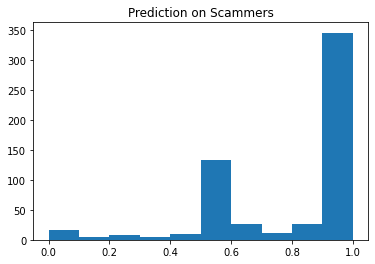

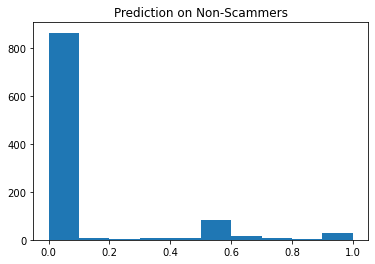

Efficiency on Scammers: 96.42248722316864 %
Efficiency on Non-Scammers: 84.8396501457726 %


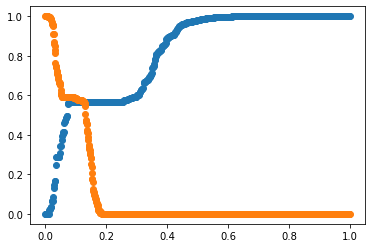

In [9]:
positives = []
negatives = []
for d in renorm_full_data:
    if d[-1] == 1:
        positives.append(np.asarray(d[:-1]))
    else:
        negatives.append(np.asarray(d[:-1]))

positives = np.asarray(positives)
negatives = np.asarray(negatives)

pred_pos = MyModel.model.predict(positives)
pred_neg = MyModel.model.predict(negatives)

plt.hist(pred_pos)
plt.title("Prediction on Scammers")
plt.show()
plt.clf()
plt.title("Prediction on Non-Scammers")
plt.hist(pred_neg)
plt.show()

eff_pos = 0
for p in pred_pos:
    if p > 0.25:
        eff_pos += 1
eff_pos /= len(pred_pos)
print("Efficiency on Scammers:",eff_pos*100,"%")

eff_neg = 0
for p in pred_neg:
    if p < 0.25:
        eff_neg += 1
eff_neg /= len(pred_neg)
print("Efficiency on Non-Scammers:",eff_neg*100
      ,"%")

integrated_pos = [ p[0] for p in pred_pos ]
integrated_pos.sort()

integrated_neg = [ p[0] for p in pred_neg ]
integrated_neg.sort(key=lambda p:-p)

integrated_pax = [ i/len(pred_pos) for i in range(len(pred_pos)) ]
integrated_nax = [ i/len(pred_neg) for i in range(len(pred_neg)) ]

plt.scatter(integrated_pax,integrated_pos)
plt.scatter(integrated_nax,integrated_neg)